$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 1: Backpropagation
<a id=part1></a>

In this part, we'll implement **backpropagation** and **automatic differentiation** from scratch and compare our implementations to `PyTorch`'s built in implementation (`autograd`).

### Porting to Google Colab
The following cell enables this notebook to run from Google Colab as well as from your local machine IDE.<br>
You can change `root_directory` and/or `this_notebook_google_path` to point to the directory in your Google account, which contains this notebook, together with the `hw2` sub-directory and its class files, the `imgs` sub-directory and the rest of the files.<br>

In [1]:
try:
    from google.colab import drive
    import sys
    import os
    root_directory = '/content/gdrive/'
    this_notebook_google_path = root_directory + 'Othercomputers/My Laptop/projects/RUNI/DL_TA/hw2'
    drive.mount(root_directory)
    # enable import python files from this notebook's path
    sys.path.append(this_notebook_google_path)
    # enable reading images and data files from this notebook's path
    os.chdir(this_notebook_google_path)
except:
    # no Google Colab --> fall back to local machine
    pass


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_single_image(file_name: str) -> None:
    # Load the images
    image1 = mpimg.imread(file_name)

    # Create subplots with 1 row and 1 columns
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    # Plot the first image on the left subplot
    axes.imshow(image1)
    axes.axis('off')  # Turn off axis
    axes.set_title(file_name)  # Set title

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [4]:
import torch
import unittest

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()

Reminder: The backpropagation algorithm is at the core of training deep models. To state the problem we'll tackle in this notebook, imagine we have an L-layer MLP model, defined as
$$
\hat{\vec{y}^i} = \vec{y}_L^i= \varphi_L \left(
\mat{W}_L \varphi_{L-1} \left( \cdots
\varphi_1 \left( \mat{W}_1 \vec{x}^i + \vec{b}_1 \right)
\cdots \right)
+ \vec{b}_L \right),
$$

a pointwise loss function $\ell(\vec{y}, \hat{\vec{y}})$ and an empirical loss over our entire data set,
$$
L(\vec{\theta}) = \frac{1}{N} \sum_{i=1}^{N} \ell(\vec{y}^i, \hat{\vec{y}^i}) + R(\vec{\theta})
$$

where $\vec{\theta}$ is a vector containing all network parameters, e.g.
$\vec{\theta} = \left[ \mat{W}_{1,:}, \vec{b}_1, \dots,  \mat{W}_{L,:}, \vec{b}_L \right]$.

In order to train our model we would like to calculate the derivative
(or **gradient**, in the multivariate case) of the loss with respect to each and every one of the parameters,
i.e. $\pderiv{L}{\mat{W}_j}$ and $\pderiv{L}{\vec{b}_j}$ for all $j$.
Since the gradient "points" to the direction of functional increase, the negative gradient is often used as a descent direction for descent-based optimization algorithms.
In other words, iteratively updating each parameter proportianally to it's negetive gradient can lead to
convergence to a local minimum of the loss function.

Calculus tells us that as long as we know the derivatives of all the functions "along the way"
($\varphi_i(\cdot),\ \ell(\cdot,\cdot),\ R(\cdot)$)
we can use the **chain rule** to calculate the derivative
of the loss with respect to any one of the parameter vectors.
Note that if the loss $L(\vec{\theta})$ is scalar (which is usually the case), the gradient of a parameter
will have the same shape as the parameter itself (matrix/vector/tensor of same dimensions).

For deep models that are a composition of many functions, calculating the gradient of each parameter by hand and implementing hard-coded gradient derivations quickly becomes infeasible.
Additionally, such code makes models hard to change, since any change potentially requires re-derivation and re-implementation of the entire gradient function.

The backpropagation algorithm, which we saw [in the lecture](https://vistalab-technion.github.io/cs236781/lecture_notes/lecture_03/#error-backpropagation), provides us with a effective method of applying the **chain rule** recursively so that we can implement gradient calculations of arbitrarily deep or complex models.

We'll now implement backpropagation using a modular approach, which will allow us to chain many components layers together and get automatic gradient calculation of the output with respect to the input or any intermediate parameter.

To do this, we'll define a `Layer` class. Here's the API of this class:

In [5]:
import hw2.layers as layers
help(layers.Layer)

Help on class Layer in module hw2.layers:

class Layer(abc.ABC)
 |  A Layer is some computation element in a network architecture which
 |  supports automatic differentiation using forward and backward functions.
 |  
 |  Method resolution order:
 |      Layer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  backward(self, dout)
 |      Computes the backward pass of the layer, i.e. the gradient
 |      calculation of the final network output with respect to each of the
 |      parameters of the forward function.
 |      :param dout: The gradient of the network with respect to the
 |      output of this layer.
 |      :return: A tuple with the same number of elements as the parameters of
 |      the forward function. Each element will be th

In other words, a `Layer` can be anything: a layer, an activation function, a loss function or generally *any computation that we know how to derive a gradient for*.

Each `Layer` must define a `forward()` function and a `backward()` function.
- The `forward()` function performs the actual calculation/operation of the block and returns an output.
- The `backward()` function computes the gradient of the **input and parameters** as a function of the gradient of the **output**, according to the chain rule.

Here's a diagram illustrating the above explanation:

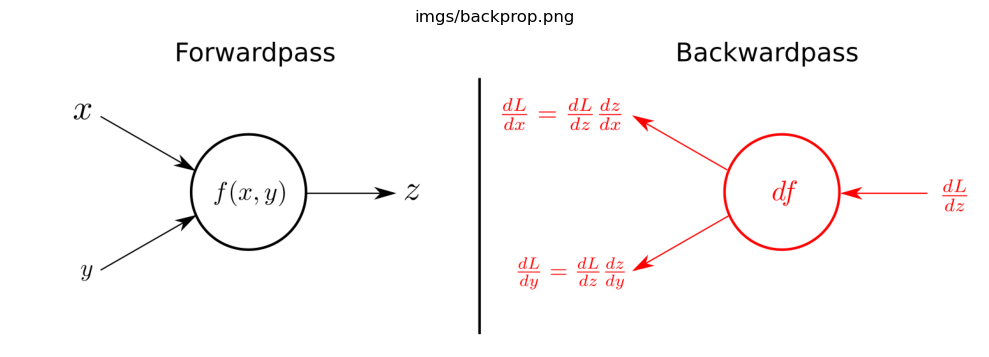

In [6]:
show_single_image("imgs/backprop.png")

Note that the diagram doesn't show that if the function is parametrized, i.e. $f(\vec{x},\vec{y})=f(\vec{x},\vec{y};\vec{w})$, there are also gradients to calculate for the parameters $\vec{w}$.

The forward pass is straightforward: just do the computation.
To understand the backward pass, imagine that there's some "downstream" loss function
$L(\vec{\theta})$ and magically somehow we are told the gradient of that loss with respect
to the **output** $\vec{z}$ of our block, i.e. $\pderiv{L}{\vec{z}}$.

Now, since we know how to calculate the derivative of $f(\vec{x},\vec{y};\vec{w})$,
it means we know how to calculate $\pderiv{\vec{z}}{\vec{x}}$, $\pderiv{\vec{z}}{\vec{y}}$ and $\pderiv{\vec{z}}{\vec{w}}$ .
Thanks to the chain rule, this is all we need to calculate the gradients of the **loss** w.r.t. the input and
parameters:

$$
\begin{align}
\pderiv{L}{\vec{x}} &= \pderiv{L}{\vec{z}}\cdot \pderiv{\vec{z}}{\vec{x}}\\
\pderiv{L}{\vec{y}} &= \pderiv{L}{\vec{z}}\cdot \pderiv{\vec{z}}{\vec{y}}\\
\pderiv{L}{\vec{w}} &= \pderiv{L}{\vec{z}}\cdot \pderiv{\vec{z}}{\vec{w}}
\end{align}
$$

## Comparison with PyTorch
<a id=part1_1></a>

PyTorch has the [`nn.Module`](https://pytorch.org/docs/stable/nn.html#module) base class, which may seem to be similar to our `Layer` since it also represents a computation element in a network.
However PyTorch's `nn.Module`s don't compute the gradient directly, they only define the forward calculations.
Instead, PyTorch has a more low-level API for defining a function and explicitly implementing it's `forward()` and `backward()`. See [`autograd.Function`](https://pytorch.org/docs/stable/autograd.html#function).
When an operation is performed on a tensor, it creates a `Function` instance which performs the operation and
stores any necessary information for calculating the gradient later on. Additionally, `Functions`s point to the
other `Function` objects representing the operations performed earlier on the tensor. Thus, a graph (or DAG)
of operations is created (this is not 100% exact, as the graph is actually composed of a different type of class which wraps the backward method, but it's accurate enough for our purposes).

A `Tensor` instance which was created by performing operations on one or more tensors with `requires_grad=True`, has a `grad_fn` property which is a `Function` instance representing the last operation performed to produce this tensor.
This exposes the graph of `Function` instances, each with it's own `backward()` function. Therefore, in PyTorch the `backward()` function is called on the tensors, not the modules.

Our `Layer`s are therefore a combination of the ideas in `Module` and `Function` and we'll implement them together,
just to make things simpler.
Our goal here is to create a "poor man's autograd": We'll use PyTorch tensors,
but we'll calculate and store the gradients in our `Layer`s (or return them).
The gradients we'll calculate are of the entire block, not individual operations on tensors.

To test our implementation, we'll use PyTorch's `autograd`.

Note that of course this method of tracking gradients is **much** more limited than what PyTorch offers. However it allows us to implement the backpropagation algorithm very simply and really see how it works.

Let's set up some testing instrumentation:

In [7]:
from hw2.grad_compare import compare_layer_to_torch

def test_block_grad(block: layers.Layer, x, y=None, delta=1e-3):
    diffs = compare_layer_to_torch(block, x, y)

    # Assert diff values
    for diff in diffs:
        test.assertLess(diff, delta)

# Show the compare function
compare_layer_to_torch??

Notes:
- After you complete your implementation, you should make sure to read and understand the `compare_layer_to_torch()` function. It will help you understand what PyTorch is doing.
- The value of `delta` above is should not be needed. A correct implementation will give you a `diff` of exactly zero.

## Layer Implementations
<a id=part1_2></a>

We'll now implement some `Layer`s that will enable us to later build an MLP model of arbitrary depth, complete with automatic differentiation.

For each block, you'll first implement the `forward()` function.
Then, you will calculate the derivative of the block by hand with respect to each of its
input tensors and each of its parameter tensors (if any).
Using your manually-calculated derivation, you can then implement the `backward()` function.

Notice that we have intermediate Jacobians that are potentially high dimensional tensors.
For example in the expression
$\pderiv{L}{\vec{w}} = \pderiv{L}{\vec{z}}\cdot \pderiv{\vec{z}}{\vec{w}}$,
the term $\pderiv{\vec{z}}{\vec{w}}$ is a 4D Jacobian if both $\vec{z}$ and $\vec{w}$
are 2D matrices.

In order to implement the backpropagation algorithm efficiently,
we need to implement every backward function without explicitly constructing this
Jacobian. Instead, we're interested in directly calculating the vector-Jacobian product
(VJP) $\pderiv{L}{\vec{z}}\cdot \pderiv{\vec{z}}{\vec{w}}$.
In order to do this, you should try to figure out the gradient of the loss with respect to
one element, e.g. $\pderiv{L}{\vec{w}_{1,1}}$ and extrapolate from there how to
directly obtain the VJP.

### Activation functions

#### (Leaky) ReLU

ReLU, or rectified linear unit is a very common activation function in deep learning architectures.
In it's most standard form, as we'll implement here, it has no parameters.

We'll first implement the "leaky" version, defined as

$$
\mathrm{relu}(\vec{x}) = \max(\alpha\vec{x},\vec{x}), \ 0\leq\alpha<1
$$

This is similar to the ReLU activation we've seen in class, only that it has a small non-zero slope then it's input is negative.
Note that it's not strictly differentiable, however it has sub-gradients, defined separately any positive-valued input and for negative-valued input.

**TODO**: Complete the implementation of the `LeakyReLU` class in the `hw2/layers.py` module.

In [8]:
N = 100
in_features = 200
num_classes = 10
eps = 1e-6

In [9]:
# Test LeakyReLU
alpha = 0.1
lrelu = layers.LeakyReLU(alpha=alpha)
x_test = torch.randn(N, in_features)

# Test forward pass
z = lrelu(x_test)
test.assertSequenceEqual(z.shape, x_test.shape)
test.assertTrue(torch.allclose(z, torch.nn.LeakyReLU(alpha)(x_test), atol=eps))

# Test backward pass
test_block_grad(lrelu, x_test)

Comparing gradients... 
input    diff=0.000


Now using the LeakyReLU, we can trivially define a regular ReLU block as a special case.

**TODO**: Complete the implementation of the `ReLU` class in the `hw2/layers.py` module.

In [12]:
# Test ReLU
relu = layers.ReLU()
x_test = torch.randn(N, in_features)

# Test forward pass
z = relu(x_test)
test.assertSequenceEqual(z.shape, x_test.shape)
test.assertTrue(torch.allclose(z, torch.relu(x_test), atol=eps))

# Test backward pass
test_block_grad(relu, x_test)

Comparing gradients... 
input    diff=0.000


#### Sigmoid

The sigmoid function $\sigma(x)$ is also sometimes used as an activation function.
We have also seen it previously in the context of logistic regression.

The sigmoid function is defined as

$$
\sigma(\vec{x}) = \frac{1}{1+\exp(-\vec{x})}.
$$

In [13]:
# Test Sigmoid
sigmoid = layers.Sigmoid()
x_test = torch.randn(N, in_features, in_features) # 3D input should work

# Test forward pass
z = sigmoid(x_test)
test.assertSequenceEqual(z.shape, x_test.shape)
test.assertTrue(torch.allclose(z, torch.sigmoid(x_test), atol=eps))

# Test backward pass
test_block_grad(sigmoid, x_test)

Comparing gradients... 
input    diff=0.000


#### Hyperbolic Tangent

The hyperbolic tangent function $\tanh(x)$ is a common activation function used when the output should be in the range \[-1, 1\].

The tanh function is defined as

$$
\tanh(\vec{x}) = \frac{\exp(x)-\exp(-x)}{\exp(x)+\exp(-\vec{x})}.
$$

In [14]:
# Test TanH
tanh = layers.TanH()
x_test = torch.randn(N, in_features, in_features) # 3D input should work

# Test forward pass
z = tanh(x_test)
test.assertSequenceEqual(z.shape, x_test.shape)
test.assertTrue(torch.allclose(z, torch.tanh(x_test), atol=eps))

# Test backward pass
test_block_grad(tanh, x_test)

Comparing gradients... 
input    diff=0.000


### Linear (fully connected) layer

First, we'll implement an affine transform layer, also known as a fully connected layer.

Given an input $\mat{X}$ the layer computes,

$$
\mat{Z} = \mat{X} \mattr{W}  + \vec{b} ,~
\mat{X}\in\set{R}^{N\times D_{\mathrm{in}}},~
\mat{W}\in\set{R}^{D_{\mathrm{out}}\times D_{\mathrm{in}}},~ \vec{b}\in\set{R}^{D_{\mathrm{out}}}.
$$

Notes:
- We write it this way to follow the implementation conventions.
- $N$ is the number of samples in the input (batch size). The input $\mat{X}$ will always be a tensor containing a batch dimension first.
- Thanks to broadcasting, $\vec{b}$ can remain a vector even though the input $\mat{X}$ is a matrix.



**TODO**: Complete the implementation of the `Linear` class in the `hw2/layers.py` module.

In [15]:
# Test Linear
out_features = 1000
fc = layers.Linear(in_features, out_features)
x_test = torch.randn(N, in_features)

# Test forward pass
z = fc(x_test)
test.assertSequenceEqual(z.shape, [N, out_features])
torch_fc = torch.nn.Linear(in_features, out_features,bias=True)
torch_fc.weight = torch.nn.Parameter(fc.w)
torch_fc.bias = torch.nn.Parameter(fc.b)
test.assertTrue(torch.allclose(torch_fc(x_test), z, atol=eps))

# Test backward pass
test_block_grad(fc, x_test)

# Test second backward pass
x_test = torch.randn(N, in_features)
z = fc(x_test)
z = fc(x_test)
test_block_grad(fc, x_test)

Comparing gradients... 
input    diff=0.000
param#01 diff=0.000
param#02 diff=0.000
Comparing gradients... 
input    diff=0.000
param#01 diff=0.000
param#02 diff=0.000


### Cross-Entropy Loss

As you know by know, cross-entropy is a common loss function for classification tasks.
In class, we defined it as

$$\ell_{\mathrm{CE}}(\vec{y},\hat{\vec{y}}) = - {\vectr{y}} \log(\hat{\vec{y}})$$

where $\hat{\vec{y}} = \mathrm{softmax}(x)$ is a probability vector (the output of softmax on the class scores $\vec{x}$) and the vector $\vec{y}$ is a 1-hot encoded class label.

However, it's tricky to compute the gradient of softmax, so instead we'll define a version of cross-entropy that produces the exact same output but works directly on the class scores $\vec{x}$.

We can write,
$$\begin{align}
\ell_{\mathrm{CE}}(\vec{y},\hat{\vec{y}}) &= - {\vectr{y}} \log(\hat{\vec{y}})
= - {\vectr{y}} \log\left(\mathrm{softmax}(\vec{x})\right) \\
&= - {\vectr{y}} \log\left(\frac{e^{\vec{x}}}{\sum_k e^{x_k}}\right) \\
&= - \log\left(\frac{e^{x_y}}{\sum_k e^{x_k}}\right) \\
&= - \left(\log\left(e^{x_y}\right) - \log\left(\sum_k e^{x_k}\right)\right)\\
&= - x_y + \log\left(\sum_k e^{x_k}\right)
\end{align}$$

Where the scalar $y$ is the correct class label, so $x_y$ is the correct class score.

Note that this version of cross entropy is also what's [provided](https://pytorch.org/docs/stable/nn.html#crossentropyloss) by PyTorch's `nn` module.

**TODO**: Complete the implementation of the `CrossEntropyLoss` class in the `hw2/layers.py` module.

In [16]:
# Test CrossEntropy
cross_entropy = layers.CrossEntropyLoss()
scores = torch.randn(N, num_classes)
labels = torch.randint(low=0, high=num_classes, size=(N,), dtype=torch.long)

# Test forward pass
loss = cross_entropy(scores, labels)
expected_loss = torch.nn.functional.cross_entropy(scores, labels)
test.assertLess(torch.abs(expected_loss-loss).item(), 1e-5)
print('loss=', loss.item())

# Test backward pass
test_block_grad(cross_entropy, scores, y=labels)

loss= 2.7283618450164795
Comparing gradients... 
input    diff=0.000


## Building Models
<a id=part1_3></a>

Now that we have some working `Layer`s, we can build an MLP model of arbitrary depth and compute end-to-end gradients.

First, lets copy an idea from PyTorch and implement our own version of the `nn.Sequential` `Module`.
This is a `Layer` which contains other `Layer`s and calls them in sequence. We'll use this to build our MLP model.

**TODO**: Complete the implementation of the `Sequential` class in the `hw2/layers.py` module.

In [17]:
# Test Sequential
# Let's create a long sequence of layers and see
# whether we can compute end-to-end gradients of the whole thing.

seq = layers.Sequential(
    layers.Linear(in_features, 100),
    layers.Linear(100, 200),
    layers.Linear(200, 100),
    layers.ReLU(),
    layers.Linear(100, 500),
    layers.LeakyReLU(alpha=0.01),
    layers.Linear(500, 200),
    layers.ReLU(),
    layers.Linear(200, 500),
    layers.LeakyReLU(alpha=0.1),
    layers.Linear(500, 1),
    layers.Sigmoid(),
)
x_test = torch.randn(N, in_features)

# Test forward pass
z = seq(x_test)
test.assertSequenceEqual(z.shape, [N, 1])

# Test backward pass
test_block_grad(seq, x_test)

Comparing gradients... 
input    diff=0.000
param#01 diff=0.000
param#02 diff=0.000
param#03 diff=0.000
param#04 diff=0.000
param#05 diff=0.000
param#06 diff=0.000
param#07 diff=0.000
param#08 diff=0.000
param#09 diff=0.000
param#10 diff=0.000
param#11 diff=0.000
param#12 diff=0.000
param#13 diff=0.000
param#14 diff=0.000


Now, equipped with a `Sequential`, all we have to do is create an MLP architecture.
We'll define our MLP with the following hyperparameters:
- Number of input features, $D$.
- Number of output classes, $C$.
- Sizes of hidden layers, $h_1,\dots,h_L$.

So the architecture will be:

FC($D$, $h_1$) $\rightarrow$ ReLU $\rightarrow$
FC($h_1$, $h_2$) $\rightarrow$ ReLU $\rightarrow$
$\cdots$ $\rightarrow$
FC($h_{L-1}$, $h_L$) $\rightarrow$ ReLU $\rightarrow$
FC($h_{L}$, $C$)

We'll also create a sequence of the above MLP and a cross-entropy loss, since it's the gradient of the loss that we need in order to train a model.

**TODO**: Complete the implementation of the `MLP` class in the `hw2/layers.py` module. Ignore the `dropout` parameter for now.

In [18]:
# Create an MLP model
mlp = layers.MLP(in_features, num_classes, hidden_features=[100, 50, 100])
print(mlp)

MLP, Sequential
	[0] Linear(self.in_features=200, self.out_features=100)
	[1] ReLU
	[2] Linear(self.in_features=100, self.out_features=50)
	[3] ReLU
	[4] Linear(self.in_features=50, self.out_features=100)
	[5] ReLU
	[6] Linear(self.in_features=100, self.out_features=10)


In [19]:
# Test MLP architecture
N = 100
in_features = 10
num_classes = 10
for activation in ('relu', 'sigmoid'):
    mlp = layers.MLP(in_features, num_classes, hidden_features=[100, 50, 100], activation=activation)
    test.assertEqual(len(mlp.sequence), 7)

    num_linear = 0
    for b1, b2 in zip(mlp.sequence, mlp.sequence[1:]):
        if (str(b2).lower() == activation):
            test.assertTrue(str(b1).startswith('Linear'))
            num_linear += 1

    test.assertTrue(str(mlp.sequence[-1]).startswith('Linear'))
    test.assertEqual(num_linear, 3)

    # Test MLP gradients
    # Test forward pass
    x_test = torch.randn(N, in_features)
    labels = torch.randint(low=0, high=num_classes, size=(N,), dtype=torch.long)
    z = mlp(x_test)
    test.assertSequenceEqual(z.shape, [N, num_classes])

    # Create a sequence of MLPs and CE loss
    seq_mlp = layers.Sequential(mlp, layers.CrossEntropyLoss())
    loss = seq_mlp(x_test, y=labels)
    test.assertEqual(loss.dim(), 0)
    print(f'MLP loss={loss}, activation={activation}')

    # Test backward pass
    test_block_grad(seq_mlp, x_test, y=labels)

MLP loss=2.309244155883789, activation=relu
Comparing gradients... 
input    diff=0.000
param#01 diff=0.000
param#02 diff=0.000
param#03 diff=0.000
param#04 diff=0.000
param#05 diff=0.000
param#06 diff=0.000
param#07 diff=0.000
param#08 diff=0.000
MLP loss=2.3934404850006104, activation=sigmoid
Comparing gradients... 
input    diff=0.000
param#01 diff=0.000
param#02 diff=0.000
param#03 diff=0.000
param#04 diff=0.000
param#05 diff=0.000
param#06 diff=0.000
param#07 diff=0.000
param#08 diff=0.000


If the above tests passed then congratulations - you've now implemented an arbitrarily deep model and loss function with end-to-end automatic differentiation!

## Questions
<a id=part2_7></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [20]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1

Suppose we have a linear (i.e. fully-connected) layer with a weight tensor $\mat{W}$, defined with `in_features=1024` and `out_features=512`. We apply this layer to an input tensor $\mat{X}$ containing a batch of `N=64` samples. The output of the layer is denoted as $\mat{Y}$.

1. Consider the Jacobian tensor $\pderiv{\mat{Y}}{\mat{X}}$ of the output of the layer w.r.t. the input $\mat{X}$.
    1. What is the shape of this tensor?
    1. Is this Jacobian sparse (most elements zero by definition)? If so, why and which elements?
    1. Given the gradient of the output w.r.t. some downstream scalar loss $L$, $\delta\mat{Y}=\pderiv{L}{\mat{Y}}$, do we need to materialize the above Jacobian in order to calculate the downstream gratdient w.r.t. to the input ($\delta\mat{X}$)? If yes, explain why; if no, show how to calcualte it without materializing the Jacobian.

1. Consider the Jacobian tensor $\pderiv{\mat{Y}}{\mat{W}}$ of the output of the layer w.r.t. the layer weights $\mat{W}$. Answer questions A-C about it as well.


In [34]:
display_answer(hw2.answers.part1_q1)


**Your answer:**
1. The shape of the Jacobian tensor for the output with respect to the input would be 
 $N \times out features \times N \times in features$. So it will be $64 \times 512 \times 64 \times 1024$.

2. The Jacobian is indeed sparse. specifically, the partial derivative is zero for all the elements that are not in the diagonal.

3. We do not need to materialize the entire Jacobian. The gradient with respect to $W$ can be computed directly using
 the chain rule. The gradient is computed as: $\delta X = \delta Y^T W$.
 This is due to the fact that: $\delta X_{jl} = \sum_{i=1}^{512} \delta y_{ji} w_{il}$.


### Question 2

Is back-propagation **required** in order to train neural networks with decent-based optimization? Why or why not?

In [35]:
display_answer(hw2.answers.part1_q2)


**Your answer:**
Back-propagation itself is not strictly required, but an efficient method for computing gradients is essential for 
training neural networks with decent-based optimization. It efficiently computes the gradients of the loss function
with respect to the weights, which are necessary for updating the weights during training. Without back-propagation,
gradient computation would be computationally expensive and impractical for large networks.
